In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import re
import gensim
import h5py
import time
from collections import Counter

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.models import load_model

%matplotlib inline
import helper_function as hf

Using TensorFlow backend.


# Loading descriptions

In [2]:
with open('data/steam_game_descriptions_2.txt', 'r') as f:
  reader = csv.reader(f)
  descriptions = list(reader)

In [3]:
descriptions = descriptions[0]

In [4]:
len(descriptions)

49556

# Loading tag names

The tags names appear in the same order as the columns of the target matrix.

In [5]:
with open('data/steam_complete_tag_list_2.txt', 'r') as f:
  reader = csv.reader(f)
  tag_names = list(reader)

In [6]:
tag_names = tag_names[0]

In [7]:
len(tag_names)

337

# Loading target matrix

A matrix with a row for each game and a column for each tag. Each element in the matrix in a binary indicator that is 1 in the columns if the game has the tag.

In [8]:
y_mat = np.load('data/steam_tag_metrix_3.npy')

In [9]:
len(y_mat)

49556

# Looking at the distribution across genres

In [10]:
aggregate = sum(y_mat)
sort_idx = sorted(range(len(aggregate)), key=lambda k: aggregate[k], reverse=True)
y_label_names = [tag_names[idx] for idx in sort_idx]

In [11]:
for idx, sorted_idx in enumerate(sort_idx):
    print(idx, tag_names[idx], aggregate[idx])

0 Animation & Modeling 433.0
1 Video Production 219.0
2 Free to Play 3662.0
3 Software 412.0
4 Movie 353.0
5 Sandbox 1858.0
6 Difficult 2158.0
7 Action 19256.0
8 Funny 1851.0
9 Comedy 1540.0
10 Singleplayer 8076.0
11 Moddable 557.0
12 Multiplayer 4637.0
13 Horror 2068.0
14 Anime 1929.0
15 First-Person 2047.0
16 Character Customization 332.0
17 Crafting 557.0
18 Great Soundtrack 3764.0
19 Strategy 12328.0
20 RTS 1009.0
21 Sci-fi 2623.0
22 Futuristic 315.0
23 RPG 9228.0
24 Open World 2587.0
25 Fantasy 2390.0
26 Third Person 1276.0
27 Adventure 15045.0
28 Medieval 409.0
29 Action RPG 641.0
30 Story Rich 2198.0
31 Dark Fantasy 318.0
32 Swordplay 91.0
33 Magic 276.0
34 Classic 1739.0
35 Multiple Endings 205.0
36 Stealth 541.0
37 Atmospheric 3212.0
38 Hack and Slash 559.0
39 Gore 739.0
40 FPS 1738.0
41 Arena Shooter 206.0
42 Competitive 449.0
43 Shooter 2282.0
44 1990's 285.0
45 Fast-Paced 567.0
46 e-sports 104.0
47 World War II 514.0
48 Retro 1685.0
49 Pixel Graphics 2215.0
50 Demons 127.0


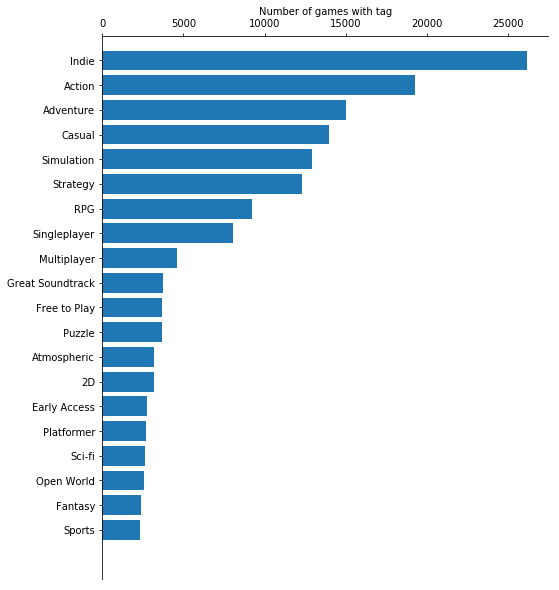

In [12]:
hf.plot_top_tags_barplot(y_label_names, aggregate, sort_idx, 20)

# Looking at a subset of the genres

Since many of the the tags, such as multiplayer, singleplayer, and free to play could belong to any genre, I have selected a subset of that tags that I bilieve will be easier and more interesting to predict.

In [13]:
idx_of_selected_tags = [
    13, 21, 22, 25, 28, 31, 33, 37,
    39, 47, 53, 59, 61, 67, 74, 77,
    78, 80, 81, 83, 84, 85, 100, 101,
    120, 122, 131, 137, 147, 148, 150,
    168, 169, 175, 182, 186, 194, 206,
    237, 241
    ]

Some of the items on steam are utility apps, such as game development or software training. The items may also be tagged with some of the tags we are interested in. We want to remove these utility apps from the dataset, since they are likely to have a different kind og description.

In [14]:
for tag_idx in idx_of_selected_tags:
    print(tag_names[tag_idx], aggregate[tag_idx])

Horror 2068.0
Sci-fi 2623.0
Futuristic 315.0
Fantasy 2390.0
Medieval 409.0
Dark Fantasy 318.0
Magic 276.0
Atmospheric 3212.0
Gore 739.0
World War II 514.0
Zombies 898.0
Mystery 707.0
Survival 1443.0
Aliens 304.0
Space 1432.0
Supernatural 75.0
Dark 531.0
Gothic 100.0
Western 112.0
War 535.0
Historical 705.0
Military 380.0
Naval 187.0
Racing 2023.0
Post-apocalyptic 384.0
Cyberpunk 397.0
Surreal 308.0
Pirates 181.0
Sports 2359.0
Robots 370.0
Survival Horror 480.0
Crime 165.0
Steampunk 303.0
Mythology 80.0
Dystopian 142.0
World War I 91.0
Psychedelic 121.0
Cold War 103.0
Psychological Horror 610.0
Dragons 141.0


In [15]:
len(idx_of_selected_tags)

40

In [16]:
idx_of_utility_tags = [
    1, 3, 303, 308, 312, 313, 314, 315
]

In [17]:
for tag_idx in idx_of_utility_tags:
    print(tag_names[tag_idx], aggregate[tag_idx])

Video Production 219.0
Software 412.0
Utilities 847.0
Audio Production 323.0
Design & Illustration 907.0
Web Publishing 458.0
Photo Editing 103.0
Software Training 225.0


# Subsetting the data

## Getting the descriptions with one or more of the subtags

Below i create two lists. One list contains the game description that meet two criteria: 1) It must contain at least one of the tags that we are interested in training our model on and 2) it must not contain any of the utility tags, since we do not want any descriptions of game development software in our dataset.

The second list is a list of the indices for the relevant description. These indices will be used to create the target matrix later.

In [18]:
relevant_description_idx = []
description_subset = []
for idx, row in enumerate(y_mat): 
    has_relevant_tag = np.sum(row[idx_of_selected_tags])>0
    has_utility_tag = np.sum(row[idx_of_utility_tags])>0 #
    if has_relevant_tag & ~has_utility_tag:
        relevant_description_idx.append(idx)
        description_subset.append(descriptions[idx])

Write code to filter out game descriptions that have no information

In [19]:
len(relevant_description_idx)

15099

An example of a game

In [20]:
print(descriptions[relevant_description_idx[3]])
tag_indices = np.where(y_mat[relevant_description_idx[3],:]>0)[0]
for idx in tag_indices:
    print(tag_names[idx])

Discover a new breed of Action-RPG game powered by an enhanced version of the Source™ Engine by Valve. Set in the Might &amp;amp; Magic® universe, players will experience ferocious combat in a dark and immersive fantasy environment. Swords, Stealth, Sorcery. Choose your way to kill.
Action
Singleplayer
Multiplayer
First-Person
RPG
Fantasy
Adventure
Medieval
Action RPG
Story Rich
Dark Fantasy
Swordplay
Magic
Classic
Multiple Endings
Stealth
Atmospheric
Hack and Slash
Gore
FPS


## Contructing the targete matrix

In [21]:
y = np.zeros( (len(description_subset), len(idx_of_selected_tags)) )
for i, relevant_game_idx in enumerate(relevant_description_idx):
    y[i,:] = y_mat[relevant_game_idx, idx_of_selected_tags]

In [22]:
for idx, col in enumerate(idx_of_selected_tags):
    print(int(np.sum(y[:, idx])), tag_names[col])

2037 Horror
2603 Sci-fi
302 Futuristic
2198 Fantasy
408 Medieval
314 Dark Fantasy
275 Magic
3195 Atmospheric
731 Gore
511 World War II
882 Zombies
705 Mystery
1438 Survival
303 Aliens
1429 Space
75 Supernatural
522 Dark
97 Gothic
110 Western
535 War
705 Historical
377 Military
187 Naval
2023 Racing
383 Post-apocalyptic
394 Cyberpunk
308 Surreal
179 Pirates
2356 Sports
370 Robots
474 Survival Horror
165 Crime
303 Steampunk
78 Mythology
140 Dystopian
91 World War I
118 Psychedelic
103 Cold War
591 Psychological Horror
132 Dragons


# Going from words to a vector

In [23]:
def sentence_to_point(description, word_model):
    words = description.split()
    game_vec = np.zeros((300,))
    for word in words:
        if word in word_model.vocab:
            word_vec = word_model.wv[word]
            game_vec = np.add(game_vec, word_vec)
    return game_vec

In [24]:
word_model = gensim.models.KeyedVectors.load_word2vec_format('./models/GoogleNews-vectors-negative300.bin', binary=True)  

In [25]:
X = np.zeros( (len(description_subset), 300) )
for idx, description in enumerate(description_subset):
    game_vec = sentence_to_point(description, word_model)
    X[idx,:] = game_vec

# Beginning machine learning

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [27]:
model = LogisticRegression()
model_collection = []
for genre in range(0,len(idx_of_selected_tags)): 
    clf_clone = clone(model)
    clf_clone.fit(X_train, y_train[:, genre])
    model_collection.append(clf_clone)

In [28]:
joblib.dump(model_collection, 'steam_model_collection.pkl') 

['steam_model_collection.pkl']

Below I make a list of only the tag names used in training the model. The list is used to form the legend in the PR and ROC plot.

In [29]:
selected_tag_names = []
for idx in idx_of_selected_tags:
    selected_tag_names.append(tag_names[idx])

Making the PR and ROC plot

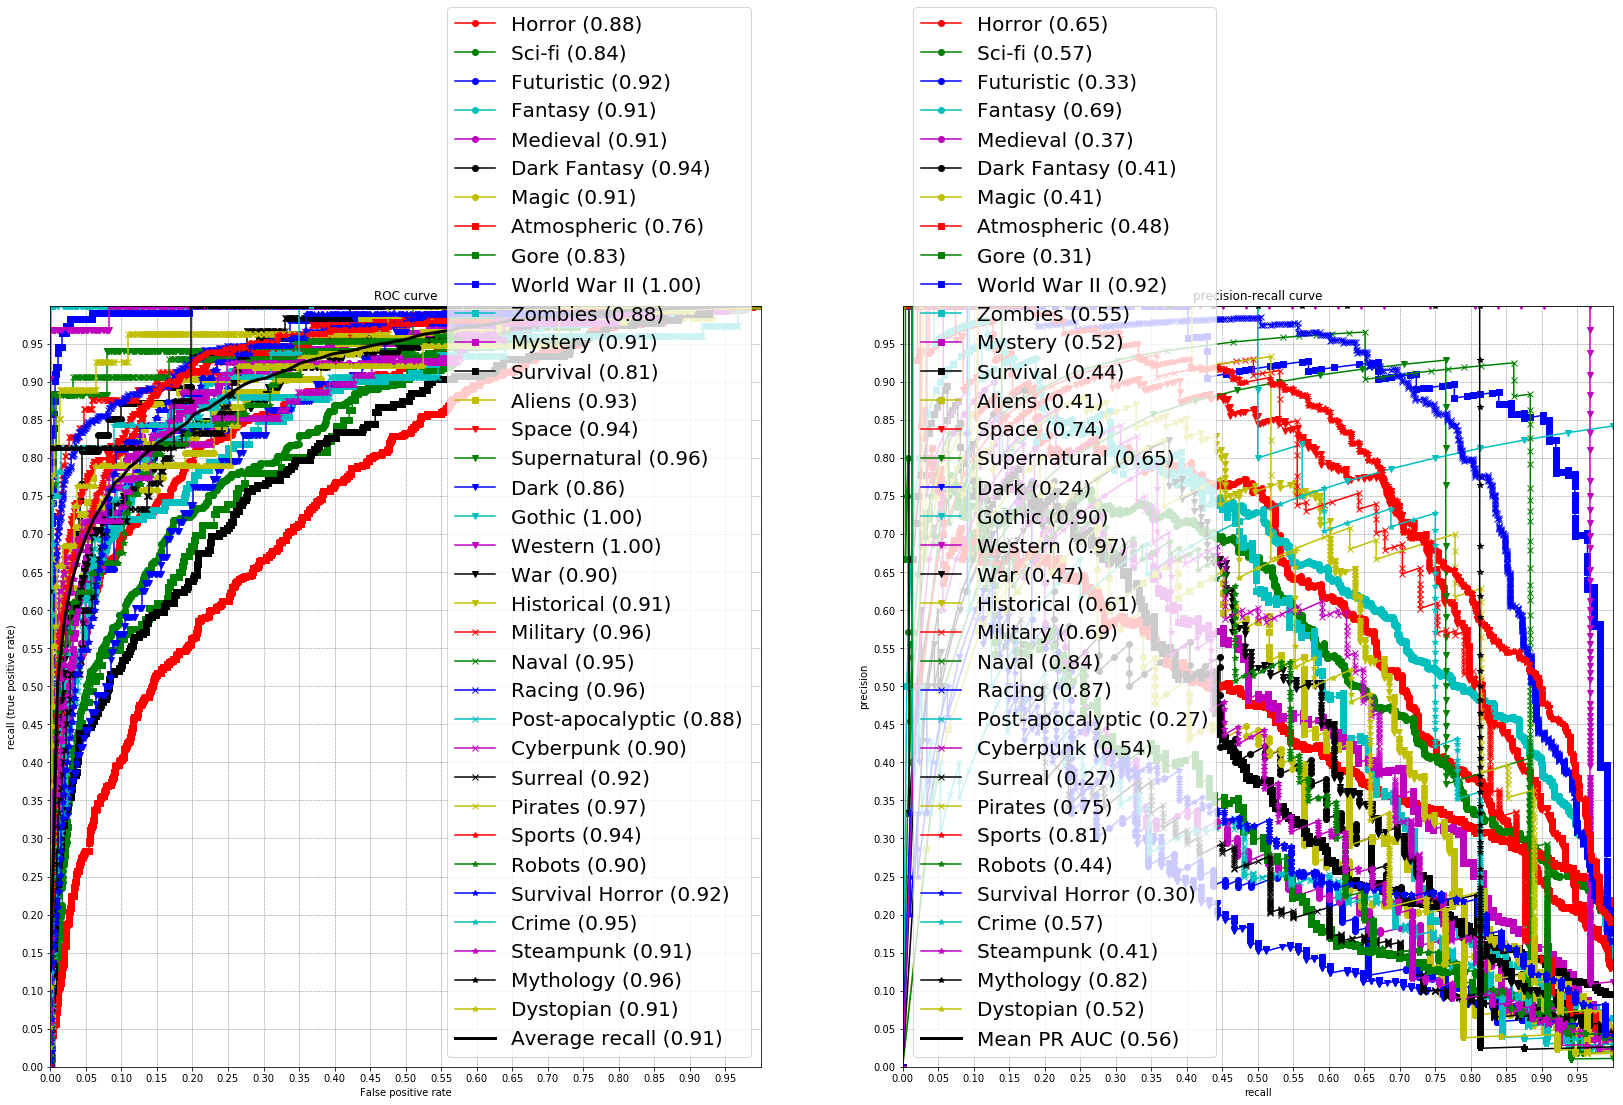

In [30]:
hf.make_roc_pr_plot(X_test, y_test, model_collection, selected_tag_names)

# Trying it out

In [31]:
example = 'In a strange future darkness lurks behind every star. With the sun about to collapse, you must find a way for the human rance to survive.'
#example = 'Madness has spread in the town. Zombies are everywhere and blood floods in the streets.'
game_vec = sentence_to_point(example, word_model)

In [32]:
pred_list = []
for idx, clf in enumerate(model_collection):
    pred = clf.predict_proba(game_vec.reshape(1, -1))
    pred_list.append(pred[:,1])

In [33]:
sort_idx = sorted(range(len(pred_list)), key=lambda k: pred_list[k], reverse=True)
my_list = [(pred_list[idx], selected_tag_names[idx]) for idx in sort_idx]
for item in my_list:
    proba = item[0][0]
    genre_name = item[1]
    print(genre_name, proba)

Horror 0.641610873668
Dark 0.349605929054
Atmospheric 0.334989660961
Sci-fi 0.259426148645
Fantasy 0.183200029989
Gothic 0.181977486222
Survival 0.0829346045295
Gore 0.0608207387746
Futuristic 0.0589868168191
Space 0.0256389195327
Steampunk 0.0251162774737
Surreal 0.0240564049402
Psychological Horror 0.0181908391051
War 0.0175178142593
Survival Horror 0.0167240327202
Zombies 0.0134080000052
Magic 0.00968511708641
Racing 0.00917271302139
Mythology 0.00684361748332
Cold War 0.00552838703148
Dark Fantasy 0.00463065534399
Cyberpunk 0.00317470839334
Post-apocalyptic 0.00301168656629
Historical 0.00276593439846
World War I 0.00227359808711
Mystery 0.00143637933347
Sports 0.00120862299362
Military 0.000701655094969
Aliens 0.000524039771416
Psychedelic 0.000521039399245
Robots 0.000347957405058
Medieval 0.000239126383232
Supernatural 8.24278831979e-05
Naval 3.94285028843e-05
Dystopian 1.69968011767e-05
Pirates 1.0628154774e-05
Crime 6.07324824553e-06
Dragons 2.40492303205e-06
World War II 1.25

# Using neural networds to do the classification

The network should be given a string of words, and not the word2vec embedding, which was used in the previous section

## Cleaning the strings a bit

In [34]:
def clean_string(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)
    # Replace numbers by x
    string = re.sub("\d", "x", string) 
    string.strip().lower()
    string = remove_stop_words(string)
    return string

def remove_stop_words(description):
    word_list = description.split()
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    description = ' '.join(filtered_words)
    return description

In [35]:
cleaned_description = []
for desc in description_subset:
    desc = clean_string(desc)
    cleaned_description.append(desc)

# Counting the occourence of words to get top N words

In [36]:
corpus = ' '.join(cleaned_description)
c = Counter(corpus.split())

The corpus contains the following number of words:

In [37]:
len(c)

35690

For the embedding we want to use only some of the words. We select the top 5000 words in this case.

In [38]:
n_words = 5000
top_n_words = c.most_common(n_words)

In [39]:
top_n_words[:5]

[('game', 4026), ('The', 3548), ('new', 2460), ('world', 1847), ('x', 1607)]

In [42]:
import pickle 
top_n_words_dict = {}
for idx, item in enumerate(top_n_words):
    word = item[0]
    top_n_words_dict[word] = idx
    
np.save('data/top_n_words_dict.npy', top_n_words_dict) 

In [ ]:
def embedding_description(desc, top_n_words_dict):
    game_embedding = []
    for idx, word in enumerate(desc.split()):
        if word in top_n_words_dict:
            word_idx = top_n_words_dict[word]
            game_embedding.append(word_idx)
        else:
            game_embedding.append(0)
    return game_embedding

In [ ]:
embedded_descriptions = []
for desc in cleaned_description:
    #game_embedding = np.zeros((len(desc.split())))
    game_embedding = []
    for idx, word in enumerate(desc.split()):
        if word in top_n_words_dict:
            word_idx = top_n_words_dict[word]
            game_embedding.append(word_idx)
        else:
            game_embedding.append(0)
    embedded_descriptions.append(game_embedding)

In [ ]:
embedded_descriptions = np.array(embedded_descriptions)

## Training a netword based on the embedding

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embedded_descriptions, y, test_size=0.2, random_state=42)

In [ ]:
type(X_train)

In [ ]:
X_train.shape

In [ ]:
maxlen = 70

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

In [ ]:
# Embedding
max_features = n_words
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 50

# Training
batch_size = 32
epochs = 15

In [ ]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.input_shape)
print(model.summary())

In [ ]:
nn_model_collection = []
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
for genre in range(0,len(idx_of_selected_tags)):
    t0 = time.time()
    model_genre = Sequential()
    model_genre.add(Embedding(max_features, embedding_size, input_length=maxlen))
    model_genre.add(Dropout(0.25))
    model_genre.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model_genre.add(MaxPooling1D(pool_size=pool_size))
    model_genre.add(LSTM(lstm_output_size))
    model_genre.add(Dense(1))
    model_genre.add(Activation('sigmoid'))

    model_genre.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model_genre.fit(X_train, y_train[:, genre],
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_data=(X_test, y_test[:, genre]))
    nn_model_collection.append(model_genre)
    model_genre.save('models/steam_nn_model_collection_' + str(genre) + '.h5')
    print('Done with run ', genre)
    t1 = time.time()
    print(np.ceil((t1-t0)/60), ' min to train the model')

In [ ]:
hf.make_roc_pr_plot(X_test, y_test, nn_model_collection, selected_tag_names)

## Trying out the network

In [ ]:
def pre_process_for_nn(string, top_n_words_dict):
    string = clean_string(string)
    embedded = embedding_description(string, top_n_words_dict)
    a = [0] * (70 - len(embedded))
    zero_padded_example = np.array(a + embedded).reshape(-1,70)
    return(zero_padded_example)

def make_example_from_index(idx):
    example = descriptions[relevant_description_idx[idx]]
    print(example)
    tag_indices = np.where(y_mat[relevant_description_idx[idx],:]>0)[0]
    for idx in tag_indices:
        print(tag_names[idx])
    return example

def make_prediction_with_nn(zero_padded_example, nn_model_collection, selected_tag_names):
    pred_list = []
    for idx, clf in enumerate(nn_model_collection):
        pred = clf.predict_proba(zero_padded_example, verbose=0)
        pred_list.append(pred)

    sort_idx = sorted(range(len(pred_list)), key=lambda k: pred_list[k], reverse=True)
    my_list = [(pred_list[idx], selected_tag_names[idx]) for idx in sort_idx]
    for item in my_list:
        proba = item[0][0][0]
        genre_name = item[1]
        if proba > 0.05:
            print(genre_name, proba)

In [ ]:
#example = 'In a strange future darkness lurks behind every star. With the sun about to collapse, you must find a way into space for the human rance to survive.'
#example = 'Madness has spread in the town. Zombies are everywhere and blood floods in the streets.'
# Selecting from the game descriptions instead

idx = 1200
example = make_example_from_index(idx)
zero_padded_example = pre_process_for_nn(example)

In [ ]:
make_prediction_with_nn(zero_padded_example, nn_model_collection, selected_tag_names)

In [ ]:
t0 = time.time()
nn_2_model_collection = []
for i in range(len(idx_of_selected_tags)):
    model = load_model('models/steam_nn_model_collection_' + str(i) + '.h5')
    nn_2_model_collection.append(model)
    if i%5==0:
        t1 = time.time()
        print((t1-t0)/60, ' min to load the models')

In [ ]:
example = make_example_from_index(7500)
zero_padded_example = pre_process_for_nn(example)
print('Predicting with neural networks ...')
t0 = time.time()
make_prediction_with_nn(zero_padded_example, nn_2_model_collection, selected_tag_names)
t1 = time.time()
print('It took ', (t1-t0)/60, ' min to make these prediction')

# Doing LSTM om the word2vec representation of the words

## Turning each word into a 300 dim vec

In [ ]:
max_words = 0
for desc in description_subset:
    length = len(desc.split())
    if length > max_words: 
        max_words = length

In [ ]:
def sentence_to_vec(description, max_words, word_model):
    sentence_vec = np.zeros( (300, max_words) )
    words = description.split()
    game_vec = np.zeros((300,))
    idx = 0
    for word in words:
        if word in word_model.vocab:
            word_vec = word_model.wv[word]
            sentence_vec[:, idx] = word_vec
            idx =+ 1
    return sentence_vec

In [ ]:
X_embedded = np.zeros( (len(description_subset), max_words , 300) )
for idx, desc in  enumerate(description_subset):
    sentence_vec = sentence_to_vec(desc, max_words, word_model)
    X_embedded[idx, :, :] = np.transpose(sentence_vec)

In [ ]:
np.shape(X_embedded)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_embedded, y, test_size=0.2)

In [ ]:
X_test.shape

# Building a simple LSTM

In [ ]:
word_vec_dim = 300

model = Sequential()
model.add(LSTM(max_words, input_shape=(max_words, word_vec_dim)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.input_shape)
print(model.summary())

In [ ]:
history = model.fit(X_train,
                    y_train[:,0],
                    epochs=10,
                    batch_size=32,
                    verbose=1,
                    validation_data=(X_test, y_test[:,0])
                   )

# The guide from Machine Learning mastery on IMDB data

The CNN LSTM neural network below is taken directly from: https://github.com/fchollet/keras/blob/master/examples/imdb_cnn_lstm.py